In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import cartopy.crs as ccrs

import sys
sys.path.insert(0, '/glade/u/home/zarzycki/sw/great_circle_calculator')
from gc_funcs.gc_functions import *

In [12]:
# module load conda
# conda activate npl-2023b

# Set the directory
dir_path = "/glade/derecho/scratch/stepheba/archive/"

# List of cases
#cases = ["b1850.054.f_outofbox"]
cases = [ "flthist134_outofbox", "flthist134.000f_ztest2", "b1850.054.f_outofbox", "b1850.054.f_ztest2"]
labels = [ "F_Lscale","F_taus","B_Lscale","B_taus" ]
colors = ['blue', 'red', 'blue', 'red']
dashes = [(1, 0), (1, 0), (1, 1), (1, 1)]  # Dash patterns: (line, space).

# Initialize storage for the mean values
mean_store = None

for case in cases:
    print(f"{dir_path}/{case}")

    # Reading the files using xarray
    fils = f"{dir_path}/{case}/atm/hist/*h0*.nc"
    ds = xr.open_mfdataset(fils, concat_dim='time', combine='nested')

    # Extracting the variable
    var = "CLOUD"
    myvar = ds[var]
    print(myvar)

    # Storing lat, lon, and lev from the first case
    if mean_store is None:
        lat = ds['lat']
        lon = ds['lon']
        lev = ds['lev']
        nlat = lat.size
        nlon = lon.size
        nlev = lev.size
        mean_store = np.zeros((len(cases), nlev, nlat, nlon))
        var_units = myvar.attrs.get('units', 'No units found')

    # Calculating the mean and storing it
    mean_store[cases.index(case), :, :, :] = myvar.mean(dim='time').values

/glade/derecho/scratch/stepheba/archive//flthist134_outofbox
<xarray.DataArray 'CLOUD' (time: 60, lev: 58, lat: 192, lon: 288)>
dask.array<concatenate, shape=(60, 58, 192, 288), dtype=float32, chunksize=(1, 58, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.3 357.5 358.8
  * lev      (lev) float64 3.018 5.445 9.087 14.25 ... 974.5 983.2 991.2 997.5
  * time     (time) object 1979-02-01 00:00:00 ... 1984-01-01 00:00:00
Attributes:
    mdims:         1
    units:         fraction
    long_name:     Cloud fraction
    cell_methods:  time: mean
/glade/derecho/scratch/stepheba/archive//flthist134.000f_ztest2
<xarray.DataArray 'CLOUD' (time: 72, lev: 58, lat: 192, lon: 288)>
dask.array<concatenate, shape=(72, 58, 192, 288), dtype=float32, chunksize=(1, 58, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.

In [15]:
leftlat, leftlon = 20.0, 195.0-360.0
rightlat, rightlon = 30.0, 235.0-360.0
npts = 100

distance, gclats, gclons = gc_latlon(leftlat, leftlon, rightlat, rightlon, npts, 2)

target_points = np.array([gclats, gclons]).T

src_lats, src_lons = np.meshgrid(lat, lon, indexing='ij')
src_lons = src_lons - 360.0
src_points = np.array([src_lats.flatten(), src_lons.flatten()]).T

interpolated_values_all_levels = np.empty((nlev, npts))

# Further processing and plotting
for ii in range(len(cases)):

    for level in range(nlev):
        
        print(f"Interpolating case number {ii} at level: {level}")        
        
        src_values = mean_store[ii, level, :, :].flatten()

        interpolated_values = griddata(src_points, src_values, target_points, method='linear')

        interpolated_values_all_levels[level, :] = interpolated_values

    if ii == 0:
        merge_trans = np.zeros((len(cases), nlev, npts))

    merge_trans[ii, :, :] = interpolated_values_all_levels

Interpolating case number 0 at level: 0
Interpolating case number 0 at level: 1
Interpolating case number 0 at level: 2
Interpolating case number 0 at level: 3
Interpolating case number 0 at level: 4
Interpolating case number 0 at level: 5
Interpolating case number 0 at level: 6
Interpolating case number 0 at level: 7
Interpolating case number 0 at level: 8
Interpolating case number 0 at level: 9
Interpolating case number 0 at level: 10
Interpolating case number 0 at level: 11
Interpolating case number 0 at level: 12
Interpolating case number 0 at level: 13
Interpolating case number 0 at level: 14
Interpolating case number 0 at level: 15
Interpolating case number 0 at level: 16
Interpolating case number 0 at level: 17
Interpolating case number 0 at level: 18
Interpolating case number 0 at level: 19
Interpolating case number 0 at level: 20
Interpolating case number 0 at level: 21
Interpolating case number 0 at level: 22
Interpolating case number 0 at level: 23
Interpolating case number 

In [4]:
# points = np.linspace(0, npts-1, npts)
# plt.figure()
# for i in range(merge_trans.shape[0]):
#     line, = plt.plot(points, merge_trans[i, :], label=labels[i], color=colors[i])
#     line.set_dashes(dashes[i])  # Set the dash pattern
#
# plt.xlabel('Points')
# plt.ylabel(var + " (" + var_units + ")")
# plt.legend()
#
# plt.xlim(0, 100)
#
# plt.show()
#

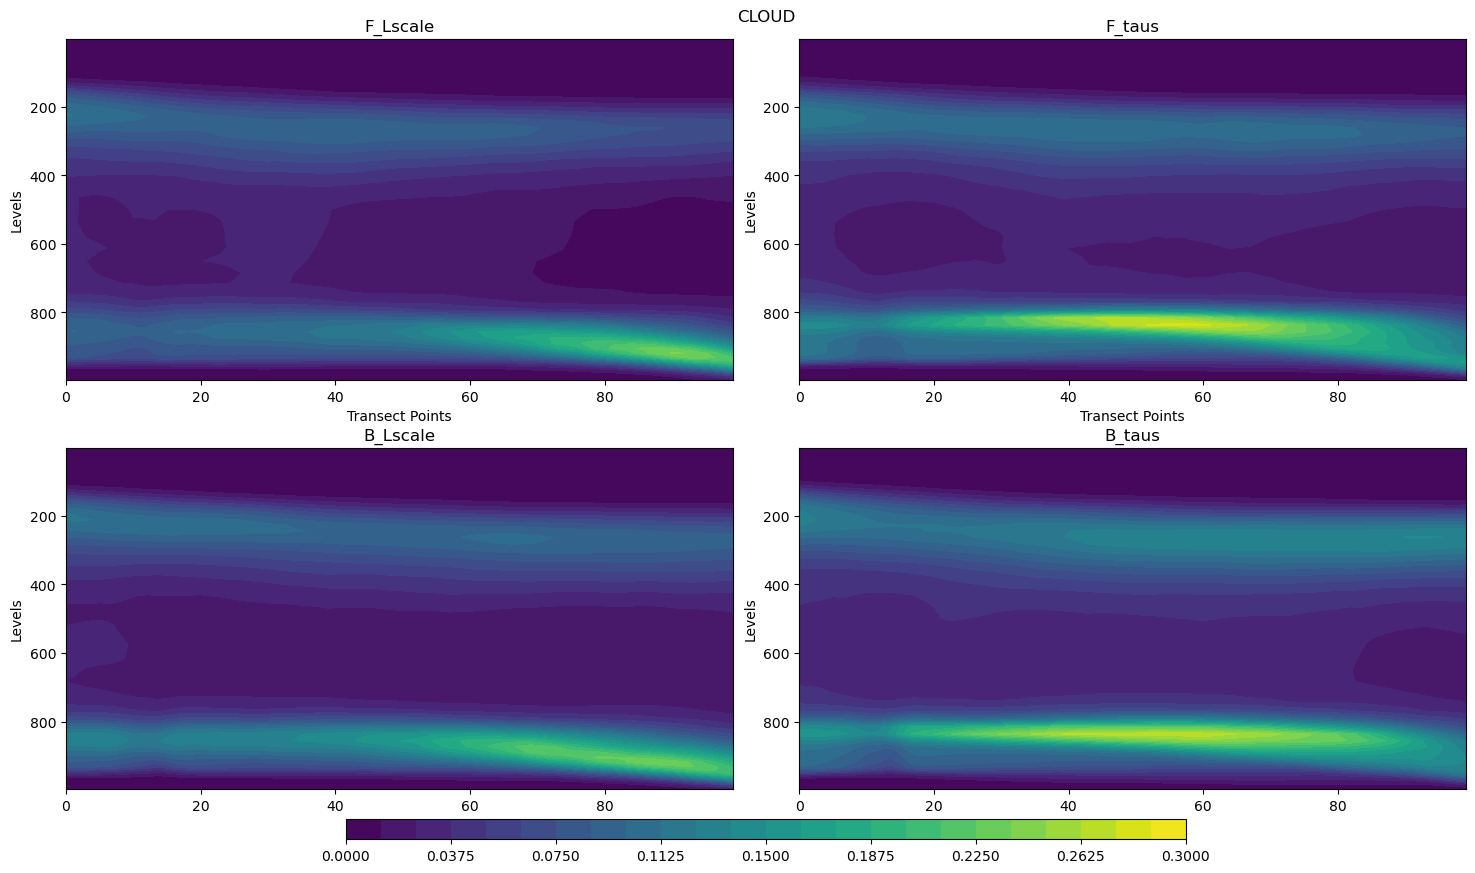

In [35]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Flatten the axs array for easy iteration
axs = axs.flatten()

vmin, vmax = 0, 0.30

# Plotting each cross-section for each case
for i in range(4):
    ax = axs[i]
    case_data = merge_trans[i, :, :]  # Data for the current case
    X, Y = np.meshgrid(range(npts), lev)  # Create meshgrid for X (transect points) and Y (levels)

    # Choose the contour levels (if needed, based on your data range)
    contour_levels = np.linspace(vmin, vmax, num=25)

    # Plot the cross-section using contourf (could also use pcolormesh)
    ctf = ax.contourf(X, Y, case_data, levels=contour_levels, cmap='viridis')

    # Set the labels and titles
    ax.set_title(labels[i])
    ax.set_xlabel('Transect Points')
    ax.set_ylabel('Levels')
    
    ax.invert_yaxis()

fig.suptitle(var)

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.0, right=1.0,
                    wspace=0.1, hspace=0.2)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.15, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(ctf, cax=cbar_ax, orientation='horizontal')

# Show the plot
plt.show()

ValueError: too many values to unpack (expected 2)

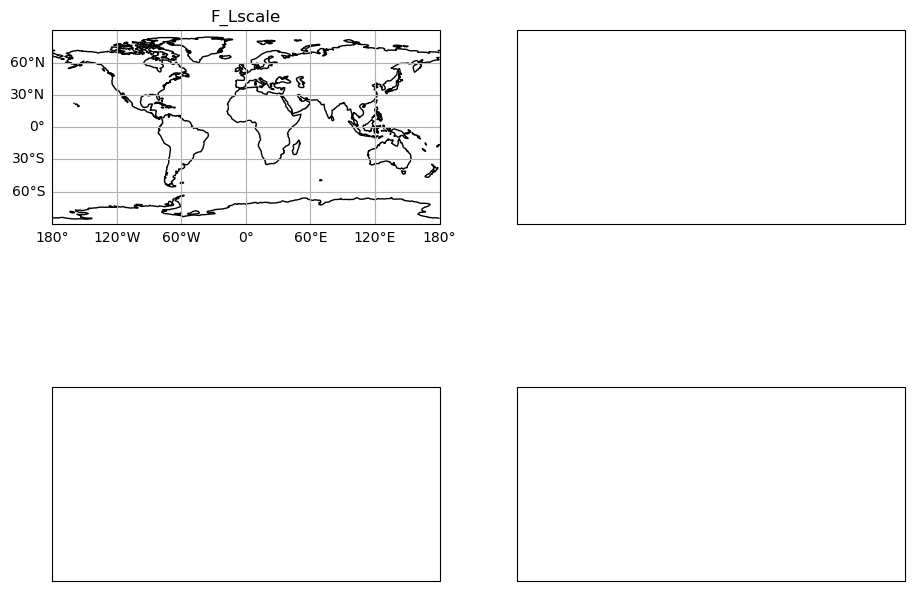

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(11, 8.5),
                        subplot_kw={'projection': ccrs.PlateCarree()})

vmin, vmax = -80, 0

cmap = plt.cm.magma_r

axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.set_title(labels[i])
    ax.coastlines()

    # Customize gridlines
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False  # Disable the top labels
    gl.right_labels = False  # Disable the right labels
    
    data = mean_store[i, :, :]
    mesh = ax.pcolormesh(lon, lat, data, shading='auto', vmin=vmin, vmax=vmax, cmap=cmap)

    #mesh=ax.contourf(lon, lat, data, vmin=vmin, vmax=vmax)

    # Add the red markers and dashed line
    ax.plot([leftlon, rightlon], [leftlat, rightlat], color='lime', 
            linewidth=2, linestyle='--', 
            transform=ccrs.Geodetic())  # Use Geodetic transform for plotting
    ax.plot(leftlon, leftlat, marker='o', color='lime', 
            markersize=5, transform=ccrs.Geodetic())
    ax.plot(rightlon, rightlat, marker='o', color='lime', 
            markersize=5, transform=ccrs.Geodetic())

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=1.0, left=0.0, right=1.0,
                    wspace=0.1, hspace=0.0)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.15, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(mesh, cax=cbar_ax,orientation='horizontal')

# Show the plot
plt.show()